In [56]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import torch
import re
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score,precision_recall_fscore_support
from Constants import *
from Misc import *
from Utils import *
from Preprocessing import DTDataset
from DeepSurvivalModels import *
tempfile = '../resources/outcomeDSMTemp.pt'
main_file = '../resources/outcomeDSM.pt'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
data = DTDataset(use_smote=False)
data.processed_df[Const.timeseries_outcomes]

,OS (Calculated),Locoregional control (Time),FDM (months),time_to_event
id,,,,
3,6.033333,4.700000,6.033333,4.700000
5,7.333333,7.333333,7.333333,6.000000
6,7.466667,7.466667,7.466667,6.000000
7,7.800000,7.800000,7.800000,6.000000
8,8.066667,8.066667,8.066667,8.066667
...,...,...,...,...
10201,143.200000,143.200000,143.200000,143.200000
10202,144.366667,144.366667,144.366667,6.000000
10203,148.366667,148.366667,136.033333,136.033333


In [61]:
dsm_model, dsm_loss, dsm_metrics = train_dsm(data, k=6, dist="LogNormal",layers=[100],elbo=False, activation='Tanh',input_dropout=.1)
dsm_loss

best pretrain loss 8157.940177520235 epochs 1259
val loss 0.7778726134154172
val metrics {'OS (Calculated)': {12: {'roc_score': 0.40909090909090906, 'f1': 0.9862068965517241, 'matthews': 0.0}, 24: {'roc_score': 0.6423796791443851, 'f1': 0.9611307420494699, 'matthews': 0.0}, 36: {'roc_score': 0.6343283582089552, 'f1': 0.9537366548042704, 'matthews': 0.0}, 48: {'roc_score': 0.6049618320610687, 'f1': 0.9424460431654677, 'matthews': 0.0}}, 'Locoregional control (Time)': {12: {'roc_score': 0.539568345323741, 'f1': 0.9720279720279721, 'matthews': 0.0}, 24: {'roc_score': 0.5348282442748091, 'f1': 0.9424460431654677, 'matthews': 0.0}, 36: {'roc_score': 0.5425196850393701, 'f1': 0.927007299270073, 'matthews': 0.0}, 48: {'roc_score': 0.541023842917251, 'f1': 0.915129151291513, 'matthews': 0.0}}, 'FDM (months)': {12: {'roc_score': 0.5425531914893618, 'f1': 0.9791666666666666, 'matthews': 0.0}, 24: {'roc_score': 0.6165327210103329, 'f1': 0.9537366548042704, 'matthews': 0.0}, 36: {'roc_score': 0.56

val loss 0.77856030366241
val metrics {'OS (Calculated)': {12: {'roc_score': 0.5052447552447552, 'f1': 0.9862068965517241, 'matthews': 0.0}, 24: {'roc_score': 0.5868983957219251, 'f1': 0.9611307420494699, 'matthews': 0.0}, 36: {'roc_score': 0.595292766934558, 'f1': 0.9537366548042704, 'matthews': 0.0}, 48: {'roc_score': 0.6192748091603053, 'f1': 0.9424460431654677, 'matthews': 0.0}}, 'Locoregional control (Time)': {12: {'roc_score': 0.5818345323741008, 'f1': 0.9720279720279721, 'matthews': 0.0}, 24: {'roc_score': 0.4971374045801526, 'f1': 0.9424460431654677, 'matthews': 0.0}, 36: {'roc_score': 0.5023622047244094, 'f1': 0.927007299270073, 'matthews': 0.0}, 48: {'roc_score': 0.526647966339411, 'f1': 0.915129151291513, 'matthews': 0.0}}, 'FDM (months)': {12: {'roc_score': 0.5531914893617021, 'f1': 0.9791666666666666, 'matthews': 0.0}, 24: {'roc_score': 0.5665901262916189, 'f1': 0.9537366548042704, 'matthews': 0.0}, 36: {'roc_score': 0.624031007751938, 'f1': 0.9347826086956522, 'matthews':

val loss 0.8301592945194567
val metrics {'OS (Calculated)': {12: {'roc_score': 0.46503496503496505, 'f1': 0.9862068965517241, 'matthews': 0.0}, 24: {'roc_score': 0.5053475935828877, 'f1': 0.9611307420494699, 'matthews': 0.0}, 36: {'roc_score': 0.5275545350172216, 'f1': 0.9537366548042704, 'matthews': 0.0}, 48: {'roc_score': 0.5658396946564885, 'f1': 0.9424460431654677, 'matthews': 0.0}}, 'Locoregional control (Time)': {12: {'roc_score': 0.5485611510791366, 'f1': 0.9720279720279721, 'matthews': 0.0}, 24: {'roc_score': 0.44322519083969464, 'f1': 0.9424460431654677, 'matthews': 0.0}, 36: {'roc_score': 0.4496062992125984, 'f1': 0.927007299270073, 'matthews': 0.0}, 48: {'roc_score': 0.47720897615708274, 'f1': 0.915129151291513, 'matthews': 0.0}}, 'FDM (months)': {12: {'roc_score': 0.4716312056737588, 'f1': 0.9791666666666666, 'matthews': 0.0}, 24: {'roc_score': 0.4856486796785304, 'f1': 0.9537366548042704, 'matthews': 0.0}, 36: {'roc_score': 0.5443583118001724, 'f1': 0.9347826086956522, 'ma

0.7688338672766721

In [62]:
dsm_metrics

{'OS (Calculated)': {12: {'roc_score': 0.43706293706293703,
   'f1': 0.9862068965517241,
   'matthews': 0.0},
  24: {'roc_score': 0.6323529411764707,
   'f1': 0.9611307420494699,
   'matthews': 0.0},
  36: {'roc_score': 0.6354764638346728,
   'f1': 0.9537366548042704,
   'matthews': 0.0},
  48: {'roc_score': 0.6011450381679388,
   'f1': 0.9424460431654677,
   'matthews': 0.0}},
 'Locoregional control (Time)': {12: {'roc_score': 0.5512589928057554,
   'f1': 0.9720279720279721,
   'matthews': 0.0},
  24: {'roc_score': 0.5267175572519084,
   'f1': 0.9424460431654677,
   'matthews': 0.0},
  36: {'roc_score': 0.5433070866141733,
   'f1': 0.927007299270073,
   'matthews': 0.0},
  48: {'roc_score': 0.5382187938288919,
   'f1': 0.915129151291513,
   'matthews': 0.0}},
 'FDM (months)': {12: {'roc_score': 0.5200945626477541,
   'f1': 0.9791666666666666,
   'matthews': 0.0},
  24: {'roc_score': 0.6400688863375431,
   'f1': 0.9537366548042704,
   'matthews': 0.0},
  36: {'roc_score': 0.61197243755

In [14]:
torch.save(dsm_model,main_file)

In [ ]:
#below is code for parameter search and evaluation figures

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
def result_df(metrics):
    result_df = []
    for outcome, outcomeresults in metrics.items():
        for months,scores in outcomeresults.items():
            for metric, score in scores.items():
                entry = {
                    'outcome': outcome,
                    'months': months,
                    'metric': metric,
                    'value': score
                }
                result_df.append(entry)
    return pd.DataFrame(result_df)
m2_df = result_df(metrics2)

In [17]:
from Utils import *
def eval_dsm(dataset,model,outcomes=Const.timeseries_outcomes):
    train_ids, test_ids = get_tt_split(dataset.processed_df.reset_index())
    
    state = 3
    xtrain = df_to_torch(dataset.get_input_state(step=state,ids=train_ids))
    xtest = df_to_torch(dataset.get_input_state(step=state,ids=test_ids))
    #n_outcomes by n_items, ytrain is event y/n, ttrain is time of event or last followup
    ytrain, ttrain = format_tte_outcomes(dataset,outcomes,ids=train_ids)
    ytest, ttest = format_tte_outcomes(dataset,outcomes,ids=test_ids)
    with torch.no_grad():
        model.eval()
        shapes2,scales2,logitss2 = model(xtest)
        val_loss = 0
        for i in range(model.n_outcomes):
            val_loss += conditional_loss(shapes2[i],scales2[i],logitss2[i],ttest[i],ytest[i],model.k,model.dist,discount=model.discount,elbo=model.elbo)/model.n_outcomes 
        val_metrics= eval_model(model,xtest,ttest,ytest,outcome_names=outcomes)
        test_metrics = eval_model(model,xtrain,ttrain,ytrain,outcome_names=outcomes)
    return {'val': val_metrics, 'train': test_metrics}

model1,model2,model3,smodel3 = load_transition_models()
mdf = result_df(eval_dsm(data,smodel3)['val'])
mdf

,outcome,months,metric,value
0,OS (Calculated),12,roc_score,0.515734
1,OS (Calculated),12,f1,0.986207
2,OS (Calculated),12,matthews,0.000000
3,OS (Calculated),24,roc_score,0.625668
4,OS (Calculated),24,f1,0.961131
5,OS (Calculated),24,matthews,0.000000
6,OS (Calculated),36,roc_score,0.637773
7,OS (Calculated),36,f1,0.953737
8,OS (Calculated),36,matthews,0.000000
9,OS (Calculated),48,roc_score,0.600668


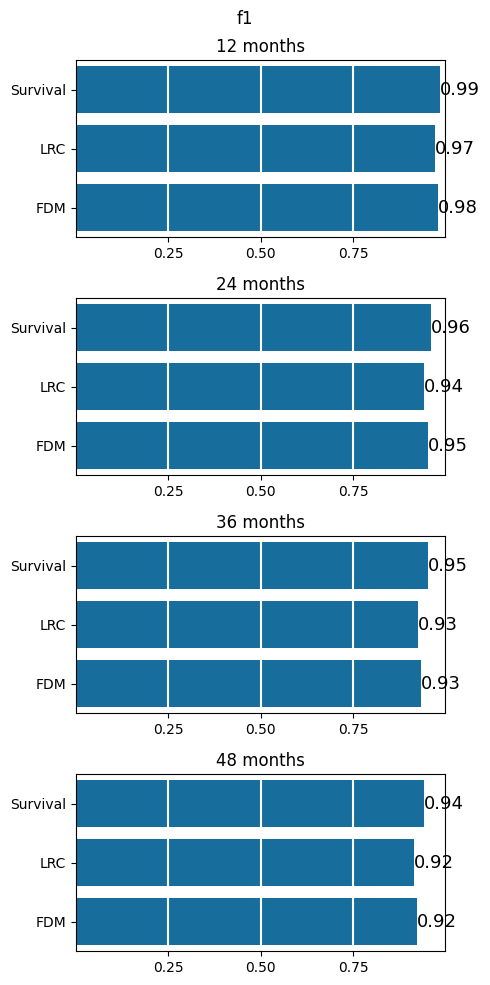

In [52]:
def plot_timeseries_outcomes_alt(df,outcome=None):
    df = df.copy()
    months = df.months.unique()
    fig,axes = plt.subplots(len(months),1,figsize=(5,10))
    if outcome is not None:
        df = df[df.metric == outcome]
    if outcome is not None:
        fig.suptitle(outcome)
    df = df[df.outcome != 'time_to_event']
    namemap = {
        'OS (Calculated)': 'Survival',
        'Locoregional control (Time)': "LRC",
        'FDM (months)': "FDM"
    }
    df.outcome = df.outcome.apply(lambda x: namemap.get(x,x))
    for i,month in enumerate(sorted(months)):
        ax = axes[i]
        subdf = df[df.months == month]
        sns.barplot(
            data=subdf,
            hue='metric',
            y='outcome',
            x='value',
            orient='h',
            ax=ax,
            palette='colorblind',
        )
        ax.set_title(str(month) + ' months',fontsize=12)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.axvline(.5,c='white')
        ax.axvline(.75,c='white')
        ax.axvline(.25,c="white")
        ax.set_xlim(0,1)
        if outcome is not None:
            ax.get_legend().remove()
        ax.set_xticks([.25,.5,.75])
    #     ax.get_legend().remove()
        for container in ax.containers:
            for patch,value in zip(container.patches,container.datavalues):
                x,y = patch.xy
                x = x + patch._width
                y = y + (patch._height/2)
                value = np.round(value,2)
                ax.text(x,y,str(value),verticalalignment='center',fontsize=13)
    fig.tight_layout()
plot_timeseries_outcomes_alt(mdf,outcome='f1')

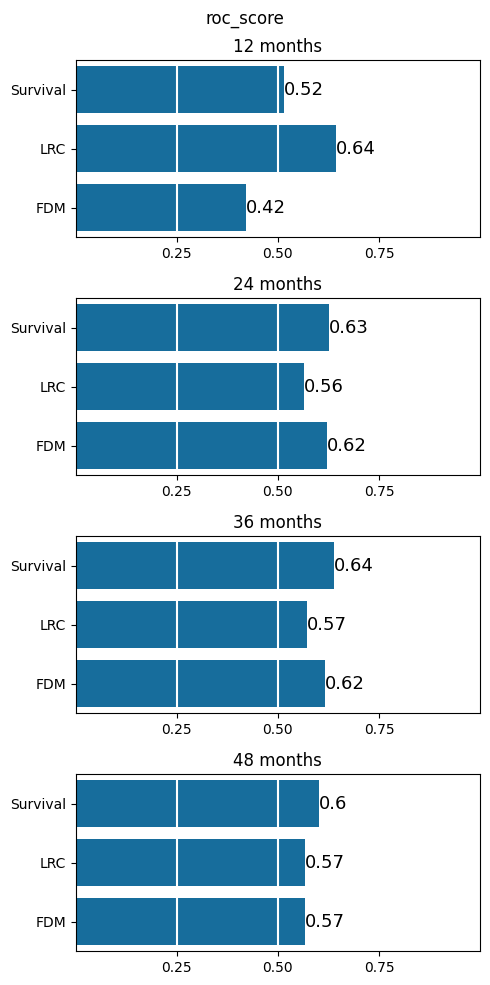

In [53]:
plot_timeseries_outcomes_alt(mdf,outcome='roc_score')

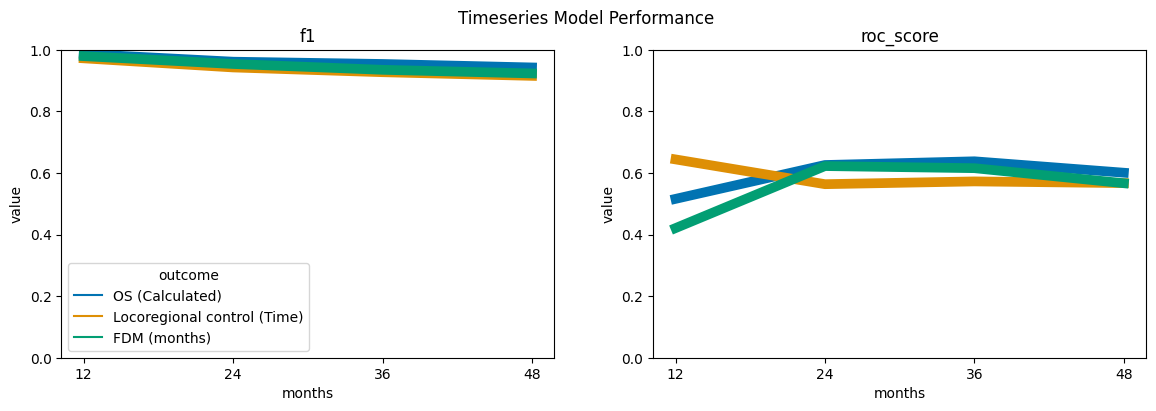

In [19]:
def plot_timeseries_outcomes(df):
    df = df.copy()
    df = df[df.outcome != 'time_to_event']
    metrics = df.metric.unique()
    metrics =[m for m in metrics if m != 'matthews']
    fig,axes = plt.subplots(1,len(metrics),figsize=(14,4))
    for i,metric in enumerate(sorted(metrics)):
        ax = axes[i]
        subdf = df[df.metric == metric]
        sns.lineplot(
            data=subdf,
            hue='outcome',
            y='value',
            x='months',
            ax=ax,
            palette='colorblind',
            linewidth=7,
            legend='brief' if i == 0 else False,
        )
        ax.set_title(metric)
        ax.set_xticks([12,24,36,48])
        ax.set_ylim(0,1)
    fig.suptitle('Timeseries Model Performance')

plot_timeseries_outcomes(mdf)

In [ ]:
#model gridsearch
from DeepSurvivalModels import *
import pickle
layer_options = [
    [500]
    [100,100],
    [100],
    [500,500]
]
results = []
best_results = {'criteria': 0}
for layers in layer_options:
    for activation in ['Tanh','Sigmoid','ReLU6']:
        for dist in ['LogNormal']:
            for k in [3,6,9]:
                for elbo in [False,True]:
                    try:
                        args = {'k': k,'dist': dist,'layers':layers,'activation':activation,'elbo':elbo}
                        model, loss, metrics = train_dsm(data,dist=dist,k=k,layers=layers,activation=activation,elbo=elbo,verbose=1)
                        criteria = np.sum([v[12]['roc_score'] + v[48]['roc_score'] + v[48]['matthews'] for v in metrics.values()])
                        entry = {
                            'model': model,
                            'loss': loss,
                            'metrics': metrics,
                            'args': args,
                            'criteria': criteria
                        }
                        results.append(entry)
                        print('-----round' + str(len(results)) + '-------')
                        print(criteria,args)
                        if criteria > best_results['criteria']:
                            model.set_device('cpu')
                            torch.save(model,tempfile)
                            best_results = {k:v for k,v in entry.items()}
                            print('++++++++_______new best______++++++++1+++')
                            print(best_results['criteria'],best_results['args'])
                            print('++++++++++++++++')
                        print()
                    except Exception as e:
                        print('^^^^^^^^^^^^^^^^^^^')
                        print('error with args',args)
                        print(e)
                        print('^^^^^^^^^^^^^^^^^^^^^^^^^^')

In [ ]:
best_results

In [ ]:
plot_timeseries_outcomes(result_df(best_results['metrics']))

In [ ]:
torch.save(best_results['model'],main_file)

In [ ]:
from DeepSurvivalModels import *

bm= train_dsm(data,dist='Weibull',k=3,layers=[100],activation='Sigmoid',elbo=False)
bm[0].time_to_event(xtr,n_samples=1)[0]

In [ ]:
times = bm[0].time_to_event(xtr,n_samples=1)[0]
for i,time in enumerate(times):
    print(time.item(), bm[0](xtr,t=time.item())[0][0][i].item())
times

In [ ]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(2,2,figsize=(20,10))
i = 0
titles= Const.timeseries_outcomes
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        scurves = torch.stack(curves[i],axis=-1).detach().cpu().numpy()
        for ii in range(scurves.shape[0]):
            axes[row][col].plot(times,scurves[ii],color='black',alpha=.1,linewidth=2)
        axes[row][col].set_title(titles[i])
        axes[row][col].set_xlabel('Weeks')
        axes[row][col].set_ylabel('Survival %')
        i += 1